# Elevation Handler
Firstly, the neccesary dependencies are imported:

In [1]:
%matplotlib widget
import os
from pathlib import Path
import sys
sys.path.append(str(Path(os.getcwd()).parent.parent))
from src.utils import print_code, download_elevation, scale_array_func, generate_subarray, transform_coordinates, resample_to_straight_axis, generate_voxel_map


import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import gzip
import os
from matplotlib.patches import Rectangle
import pyproj
from scipy.interpolate import RectBivariateSpline
from cartopy.io.img_tiles import GoogleTiles
import cartopy.crs as ccrs
from matplotlib.ticker import AutoLocator
# from utils import print_code, download_elevation, scale_array_func, generate_subarray, transform_coordinates, resample_to_straight_axis, generate_voxel_map
from IPython.core.display import HTML
from scipy.interpolate import griddata
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable

For map data the Shuttle Radar Topography Mission 30-Meter SRTM Elevation Data is used. The data can be downloaded in a resolution of 1° x 1°.

In [2]:
HTML(print_code(download_elevation))

Now let's test the function.

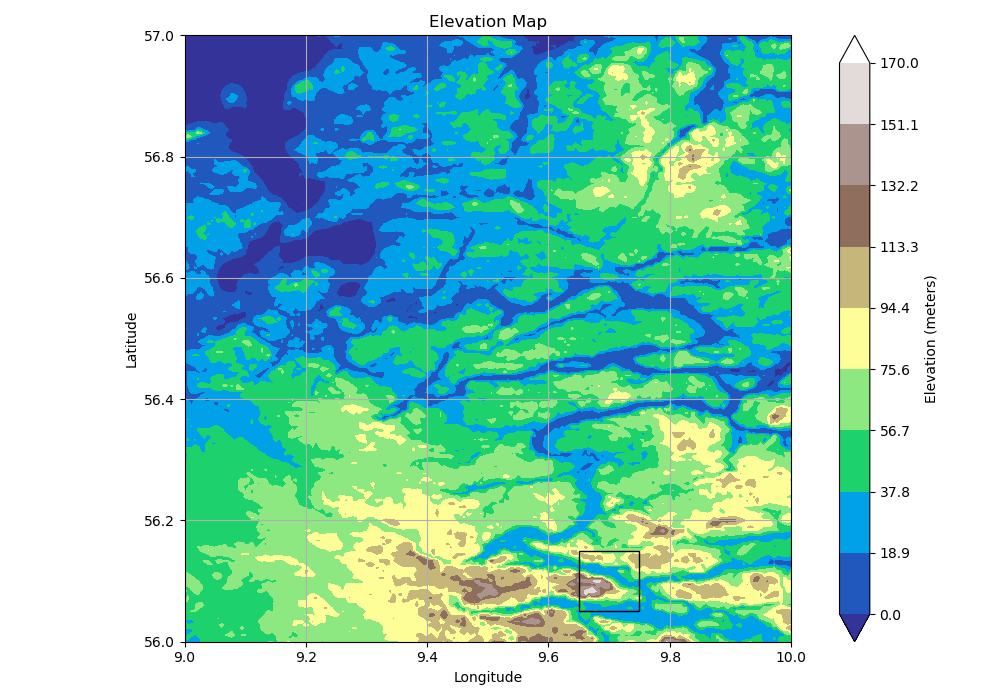

In [3]:
map_boundaries = np.array([9.65, 9.75, 56.05, 56.15])
# longitude, latitude
#  45.184824127006706, 6.356677460471748 47.5930208421994, 9.723481445784927
# map_boundaries = np.array([55.22, 55.7, 12.42, 12.7])

srtm_longitude, srtm_latitude, merged_map = download_elevation(map_boundaries)
scale = 20

vmin = 0
vmax = float('%.2g' % np.max(merged_map)) # round down to two significant digits
levels = np.linspace(vmin, vmax, 10)

fig, ax = plt.subplots(figsize = (10, 7))
ct = ax.contourf(srtm_longitude[::scale], srtm_latitude[::scale], merged_map[::scale, ::scale], 
                 levels = levels, vmin = vmin, vmax = vmax, extend = "both",
                 cmap='terrain')
plt.colorbar(ct, ax = ax, label='Elevation (meters)')

# Add the rectangle to the plot
rect = Rectangle(
    xy=(map_boundaries[0], map_boundaries[2]),  # bottom-left corner
    width=(map_boundaries[1] - map_boundaries[0]),  # width
    height=(map_boundaries[3] - map_boundaries[2]),  # height
    linewidth=1,
    edgecolor='k',
    facecolor='none'
)

ax.add_patch(rect)
rect.set_zorder(3)

ax.grid()
ax.set_aspect('equal')
ax.set_title('Elevation Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

As the dataset is too large to work with, a function is used to scale it down.

In [4]:
HTML(print_code(scale_array_func))

In [5]:
merged_map, srtm_longitude, srtm_latitude = scale_array_func(merged_map, srtm_longitude, srtm_latitude, new_shape = [1000, 1000], scaling_factor = 0.25)

Now limit the of the image (Indicated by the black border)

In [6]:
HTML(print_code(generate_subarray))

Test

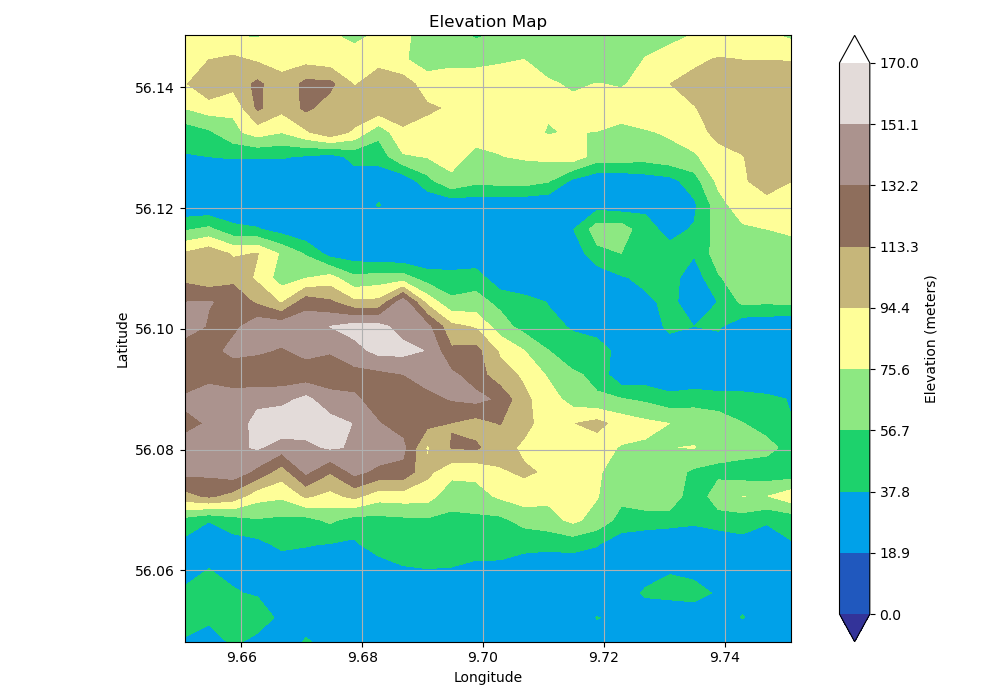

In [7]:
map_array, sublong_points, sublat_points, subarray_bounds = generate_subarray(merged_map, srtm_longitude, srtm_latitude, map_boundaries)

vmin = np.minimum(0, float('%.2g' % np.max(map_array)))
vmax = np.maximum(0, float('%.2g' % np.max(map_array))) # round down to two significant digits
levels = np.linspace(vmin, vmax, 10)

fig, ax = plt.subplots(figsize = (10, 7))
ct = ax.contourf(sublong_points, sublat_points, map_array, 
                levels = levels, vmin = vmin, vmax = vmax, extend = "both",
                cmap='terrain')
plt.colorbar(ct, ax = ax, label='Elevation (meters)')

ax.grid()
ax.set_aspect('equal')
ax.set_title('Elevation Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

Code to transform the coordinates

In [8]:
HTML(print_code(transform_coordinates))

Run the code

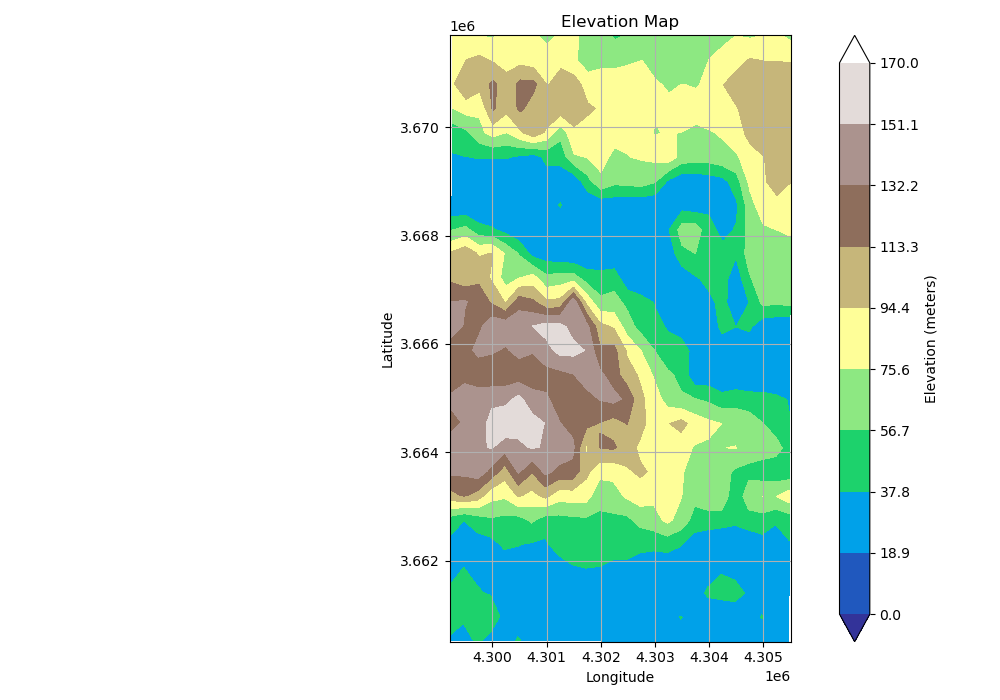

In [9]:
trans_cords = transform_coordinates(sublong_points, sublat_points, input_crs_str = "EPSG:4326", output_crs_str = "EPSG:3035")

vmin = np.minimum(0, float('%.2g' % np.max(map_array)))
vmax = np.maximum(0, float('%.2g' % np.max(map_array))) # round down to two significant digits
levels = np.linspace(vmin, vmax, 10)

fig, ax = plt.subplots(figsize = (10, 7))

ct = ax.contourf(trans_cords[:,:,0], trans_cords[:,:,1], map_array, 
                levels = levels, vmin = vmin, vmax = vmax, extend = "both",
                cmap='terrain')
plt.colorbar(ct, ax = ax, label='Elevation (meters)')

ax.grid()
ax.set_aspect('equal')
ax.set_title('Elevation Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.tight_layout()
plt.show()

As the transformation to the different Coordinate Reference Systems (CRS) slightly rotates the map (especially on a larger lengthscale). The following function generates a subarray of the original array with striaght axis using cubic interpolation.

In [10]:
HTML(print_code(resample_to_straight_axis))

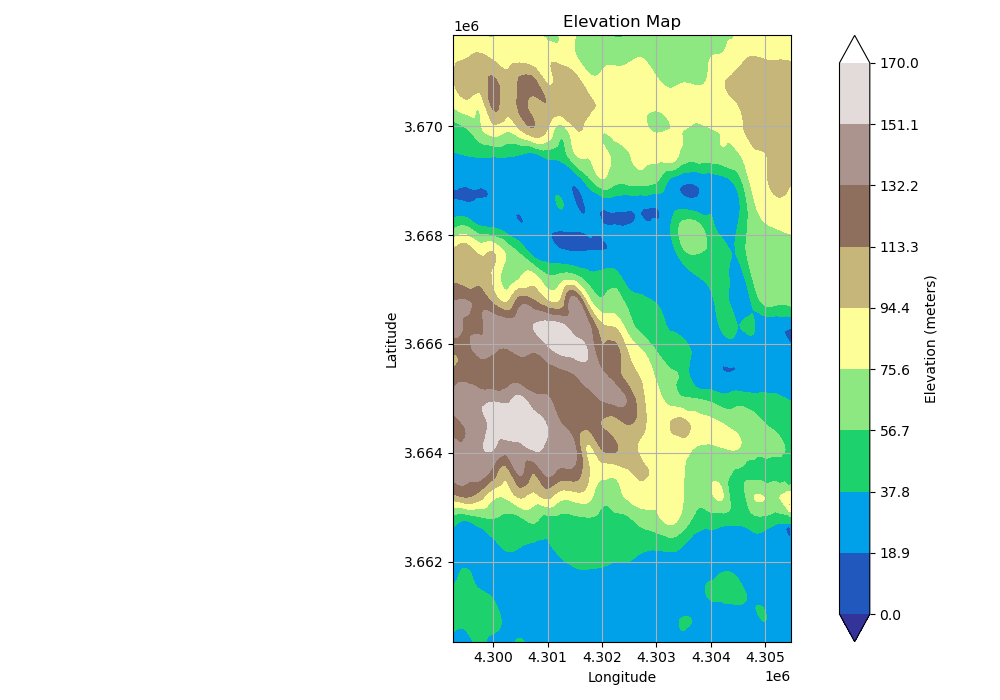

In [11]:
shape = [200, 200]
X, Y, Z = resample_to_straight_axis(trans_cords, map_array, shape)
vmin = np.minimum(0, float('%.2g' % np.max(Z)))
vmax = np.maximum(0, float('%.2g' % np.max(Z))) # round down to two significant digits
levels = np.linspace(vmin, vmax, 10)

fig, ax = plt.subplots(figsize = (10, 7))

ct = ax.contourf(X, Y, Z, 
                levels = levels, vmin = vmin, vmax = vmax, extend = "both",
                cmap='terrain')
plt.colorbar(ct, ax = ax, label='Elevation (meters)')

ax.grid()
ax.set_aspect('equal')
ax.set_title('Elevation Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.tight_layout()
plt.show()

Add Google Maps layer

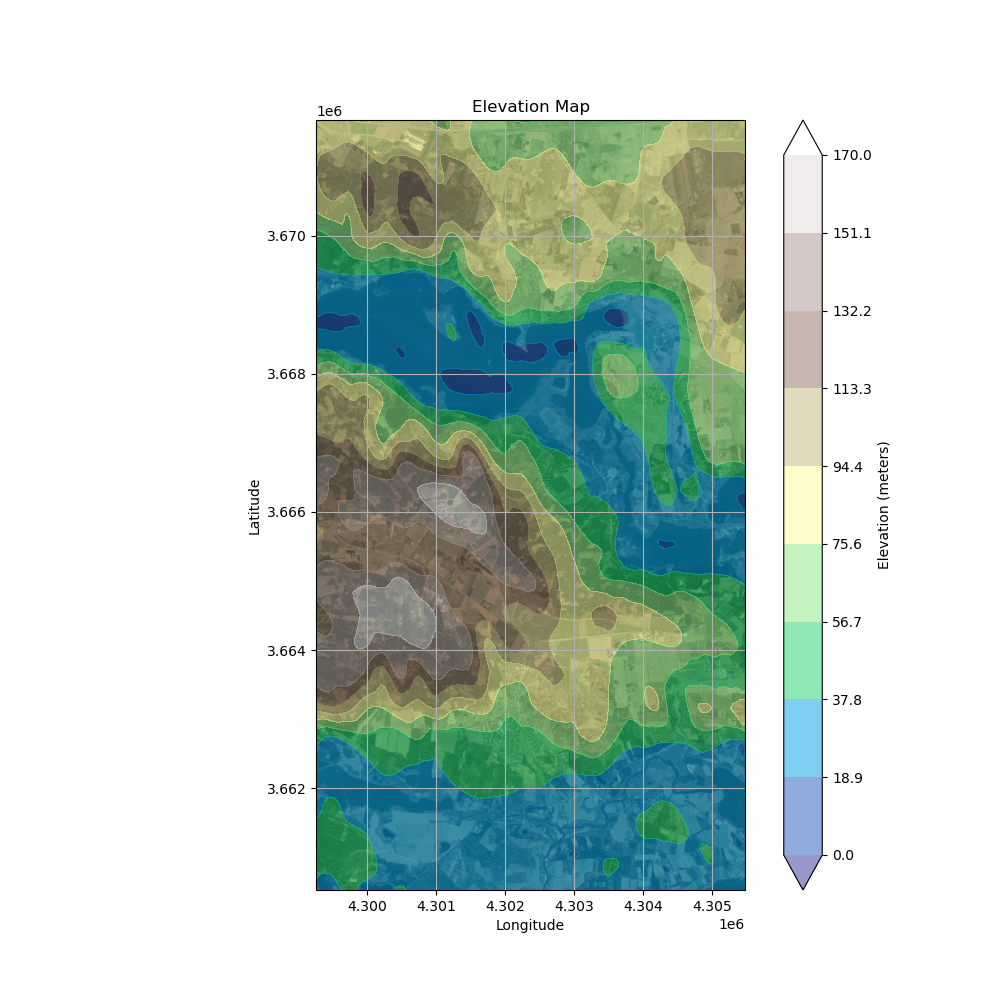

In [12]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.epsg(3035)}, figsize=(10, 10))


vmin = np.minimum(0, float('%.2g' % np.max(Z)))
vmax = np.maximum(0, float('%.2g' % np.max(Z))) # round down to two significant digits
levels = np.linspace(vmin, vmax, 10)

# ct = ax.contourf(trans_cords[:,:,0], trans_cords[:,:,1], map_array, 
#                 levels = levels, vmin = vmin, vmax = vmax, extend = "both",
#                 cmap='terrain', alpha = 0.5)


ct = ax.contourf(X, Y, Z, 
                levels = levels, vmin = vmin, vmax = vmax, extend = "both",
                cmap='terrain', alpha = 0.5)

plt.colorbar(ct, ax = ax, label='Elevation (meters)')

# ax.set_extent(map_boundaries)
imagery = GoogleTiles(style = "satellite") # Valid styles: street, satellite, terrain, only_streets
ax.add_image(imagery, 14) # 16

# For some reason, the ticks needs to be overriden ([0]) before AutoLocator can be used.
ax.set_xticks([0], crs=ccrs.epsg(3035))
ax.set_yticks([0], crs=ccrs.epsg(3035))
ax.xaxis.set_major_locator(AutoLocator())
ax.yaxis.set_major_locator(AutoLocator())

plt.grid()
ax.set_aspect('equal')
ax.set_title('Elevation Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

Convert map to voxel

In [13]:
HTML(print_code(generate_voxel_map))

In [14]:
map_boundaries = np.array([9.65, 9.75, 56.05, 56.15])
shape = [200, 200]
X, Y, voxel_map, map_array = generate_voxel_map(map_boundaries, shape)

In [15]:
import ipywidgets
@ipywidgets.interact(Level=(0, voxel_map.shape[2]-1))
def plot_map(Level):
    colors = ["blue", "brown"]
    cmap = ListedColormap(colors)
    sm = ScalarMappable(cmap=cmap)
    sm.set_array(voxel_map)
    fig, ax = plt.subplots(figsize = (10, 7))
    ct = ax.pcolormesh(X, Y, voxel_map[:, :, Level],        
                    cmap=cmap, alpha = 0.5)

    plt.colorbar(sm, ax = ax, label='<-- Below (Level) Above -->', ticks = [0, 1])

    ax.grid()
    ax.set_aspect('equal')
    ax.set_title('Elevation Map')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=78, description='Level', max=157), Output()), _dom_classes=('widget-inte…